In [1]:
%pylab inline
# Just some initial setup and imports
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
import numpy as np
import math
import gym

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create a non-skid version of Frozen Lake
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonskid8x8-v0'
try:
    spec(MY_ENV_NAME)
except:
    register(
        id=MY_ENV_NAME,
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '8x8', 'is_slippery': False},
        timestep_limit=100,
        reward_threshold=0.78, # optimum = .8196
    )
env = gym.make(MY_ENV_NAME)

[2017-01-11 18:58:34,210] Making new env: FrozenLakeNonskid8x8-v0


In [3]:
# This helper is for later. 
def to_onehot(size,value):
    my_onehot = np.zeros((size))
    my_onehot[value] = 1.0
    return my_onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR= int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD

actor_model = Sequential()
actor_model.add(Dense(164, init='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
actor_model.add(Activation('relu'))

actor_model.add(Dense(150, init='lecun_uniform'))
actor_model.add(Activation('relu'))

actor_model.add(Dense(ACTION_SPACE, init='lecun_uniform'))
actor_model.add(Activation('linear'))

a_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
actor_model.compile(loss='mse', optimizer=a_optimizer)

Using TensorFlow backend.


In [5]:
critic_model = Sequential()

critic_model = Sequential()
critic_model.add(Dense(164, init='lecun_uniform', input_shape=(OBSERVATION_SPACE,)))
critic_model.add(Activation('relu'))
critic_model.add(Dense(150, init='lecun_uniform'))
critic_model.add(Activation('relu'))
critic_model.add(Dense(1, init='lecun_uniform'))
critic_model.add(Activation('linear'))

c_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
critic_model.compile(loss='mse', optimizer=c_optimizer)

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



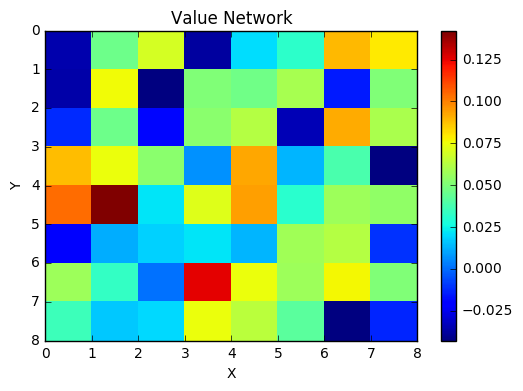

In [6]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            # And now have the critic model predict the state value
            # with the player in that location.
            value = critic_model.predict(my_state.reshape(1, OBSERVATION_SPACE))
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()


env.reset()
env.render()
plot_value(STATEGRID)

Zeroing out critic network...
Done!


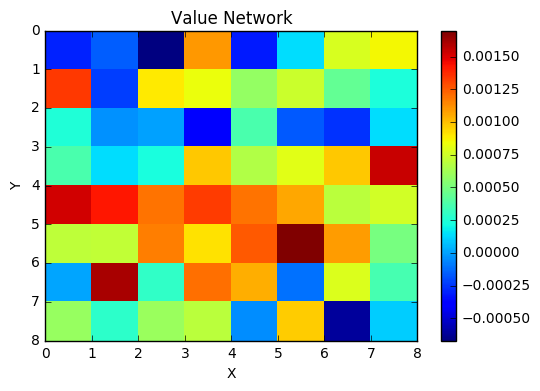

In [7]:
def zero_critic(epochs=100):
    for i in range(epochs):
        for j in range(OBSERVATION_SPACE):
            X_train = []
            y_train = []
            
            y = np.empty([1])
            y[0]=0.0
            x = to_onehot(OBSERVATION_SPACE,j)
            X_train.append(x.reshape((OBSERVATION_SPACE,)))
            y_train.append(y.reshape((1,)))
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            critic_model.fit(X_train, y_train, batch_size=1, nb_epoch=1, verbose=0)

print("Zeroing out critic network...")
sys.stdout.flush()
zero_critic()
print("Done!")
plot_value(STATEGRID)

In [8]:
from IPython.display import clear_output
import random
import time

def trainer(epochs=1000, batchSize=40, 
            gamma=0.975, epsilon=1, min_epsilon=0.1,
            buffer=80):
    
    wins = 0
    losses = 0
    # Replay buffers
    actor_replay = []
    critic_replay = []
    
    for i in range(epochs):

        observation = env.reset()
        done = False
        reward = 0
        info = None
        move_counter = 0

        while(not done):
            # Get original state, original reward, and critic's value for this state.
            orig_state = to_onehot(OBSERVATION_SPACE,observation)
            orig_reward = reward
            orig_val = critic_model.predict(orig_state.reshape(1,OBSERVATION_SPACE))

            if (random.random() < epsilon): #choose random action
                action = np.random.randint(0,ACTION_SPACE)
            else: #choose best action from Q(s,a) values
                qval = actor_model.predict( orig_state.reshape(1,OBSERVATION_SPACE) )
                action = (np.argmax(qval))
                
            #Take action, observe new state S'
            new_observation, new_reward, done, info = env.step(action)
            new_state = to_onehot(OBSERVATION_SPACE,new_observation)
            # Critic's value for this new state.
            new_val = critic_model.predict(new_state.reshape(1,OBSERVATION_SPACE))
            
            if not done: # Non-terminal state.
                target = orig_reward + ( gamma * new_val)
            else:
                # In terminal states, the environment tells us
                # the value directly.
                target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
            best_val = max((orig_val*gamma), target)

            # Now append this to our critic replay buffer.
            critic_replay.append([orig_state,best_val])
            # If we are in a terminal state, append a replay for it also.
            if done:
                critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
            actor_delta = new_val - orig_val
            actor_replay.append([orig_state, action, actor_delta])
            
            # Critic Replays...
            while(len(critic_replay) > buffer): # Trim replay buffer
                critic_replay.pop(0)
            # Start training when we have enough samples.
            if(len(critic_replay) >= buffer):
                minibatch = random.sample(critic_replay, batchSize)
                X_train = []
                y_train = []
                for memory in minibatch:
                    m_state, m_value = memory
                    y = np.empty([1])
                    y[0] = m_value
                    X_train.append(m_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((1,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
            # Actor Replays...
            while(len(actor_replay) > buffer):
                actor_replay.pop(0)                
            if(len(actor_replay) >= buffer):
                X_train = []
                y_train = []
                minibatch = random.sample(actor_replay, batchSize)
                for memory in minibatch:
                    m_orig_state, m_action, m_value = memory
                    old_qval = actor_model.predict( m_orig_state.reshape(1,OBSERVATION_SPACE,) )
                    y = np.zeros(( 1, ACTION_SPACE ))
                    y[:] = old_qval[:]
                    y[0][m_action] = m_value
                    X_train.append(m_orig_state.reshape((OBSERVATION_SPACE,)))
                    y_train.append(y.reshape((ACTION_SPACE,)))
                X_train = np.array(X_train)
                y_train = np.array(y_train)
                actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

            # Bookkeeping at the end of the turn.
            observation = new_observation
            reward = new_reward
            move_counter+=1
            if done:
                if new_reward > 0 : # Win
                    wins += 1
                else: # Loss
                    losses += 1
        # Finised Epoch
        clear_output(wait=True)
        print("Game #: %s" % (i,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
        if epsilon > min_epsilon:
            epsilon -= (1/epochs)

In [9]:
%%time
trainer()

Game #: 705
Moves this round 53
Final Position:
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
Wins/Losses 0/706


KeyboardInterrupt: 

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)


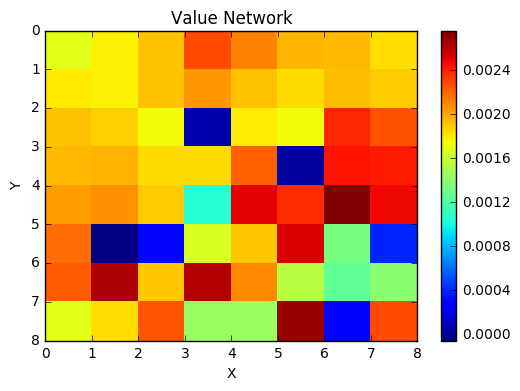

In [10]:
env.reset()
env.render()
plot_value(STATEGRID)

In [11]:
# Maps actions to arrows to indicate move direction.
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    #working_state = initial_state.copy()
    #p = findLoc(working_state, np.array([0,0,0,1]))
    #working_state[p[0],p[1]] = np.array([0,0,0,0])
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            #for a in range(0, 4):
            my_state = initial_state.copy()
            my_state[x,y] = 1
            #
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            qval = actor_model.predict(obs_predict)
            #print(obs_predict)
            
            action = (np.argmax(qval))
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()
print(show_policy(STATEGRID))

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
[[u'v' u'>' u'>' u'^' u'<' u'v' u'<' u'v']
 [u'<' u'v' u'>' u'^' u'^' u'>' u'v' u'v']
 [u'>' u'<' u'^' u'v' u'v' u'^' u'>' u'v']
 [u'v' u'v' u'<' u'>' u'v' u'>' u'v' u'^']
 [u'v' u'<' u'>' u'<' u'>' u'v' u'^' u'<']
 [u'v' u'v' u'<' u'^' u'>' u'>' u'<' u'>']
 [u'>' u'v' u'<' u'>' u'v' u'>' u'v' u'<']
 [u'^' u'>' u'<' u'>' u'v' u'^' u'>' u'v']]


In [12]:
def play(render_every_step=False):
    observation = env.reset()
    done = False
    reward = 0.0
    max_moves = 40
    move_counter = 0
    while not done and move_counter < max_moves:
        state = to_onehot(OBSERVATION_SPACE,observation)
        qval = actor_model.predict( state.reshape(1,OBSERVATION_SPACE) )
        action = (np.argmax(qval))
        observation, reward, done, info = env.step(action)
        print(A2A[action])
        if render_every_step:
            env.render()
        move_counter += 1
    env.render()

play(render_every_step=True)

v
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
<
SF